In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data

In [2]:
n = 10 # number of files
# format n to have 5 number places
files = [f'../preprocessed/events-{str(i).zfill(5)}.pkl' for i in range(1, n+1)]

# Create graph

In [3]:
G = nx.Graph()

## Add nodes

In [4]:
def get_event_features(event):
    info = event['info']
    articleCounts, multiLingInfo, eventDate = info['articleCounts'], info['multiLingInfo'], info['eventDate']
    
    return {
        'articleCounts': articleCounts,
        'multiLingInfo': multiLingInfo,
        'eventDate': eventDate
    }

In [5]:
def get_concept_features(c):
    return {
        'labelEng': c['labelEng'],
        'type': c['type'],
        'uri': c['uri']
    }

In [6]:
def get_id(orig_id, prefix):
    return f"{prefix}_{orig_id}"

In [7]:
for file in files:
    df = pd.read_pickle(file)
    for i, event in df.iterrows():
        info, similar_events = event['info'], event['similarEvents']
        event_id = get_id(info['uri'], 'e')
        
        G.add_node(event_id, **get_event_features(event))
        
        # concepts = info['concepts']
        # for concept in concepts:
        #     concept_id = get_id(concept['id'], 'c')
        #     G.add_node(concept_id, **get_concept_features(concept))
        #     G.add_edge(event_id, concept_id, edge_type='concept', weight=concept['score'])
        
        for similar_event in similar_events:
            similar_id = get_id(similar_event['uri'], 'e')
            G.add_node(similar_id, eventDate=similar_event['eventDate'])
            G.add_edge(event_id, similar_id, edge_type='similar', weight=similar_event['sim'])
        

## Similarity score

We confirmed that the similarity score is symmetric.

In [8]:
# for n1 in G.nodes():
#     for n2 in G.nodes():
#         if n1 == n2:
#             continue
#         if G.has_edge(n1, n2) and G.has_edge(n2, n1):
#             print(n1, n2, G.edges[n1, n2], G.edges[n2, n1])
#             break

## Article count analysis

Average article count, median article count, and standard deviation of article count.

In [9]:
def has_counts(node):
    return 'articleCounts' in node and 'total' in node['articleCounts']

In [10]:
def get_counts(nodes):
    return [G.nodes[n]['articleCounts']['total'] for n in nodes if has_counts(G.nodes[n])]

In [11]:
article_counts = get_counts(G.nodes())

In [12]:
print(f'Events with article counts: {len(article_counts)}')
print(f'Average article count: {np.average(article_counts)}')
print(f'Median article count: {np.median(article_counts)}')
print(f'Standard deviation of article count: {np.std(article_counts)}')


Events with article counts: 7241
Average article count: 11.97624637481011
Median article count: 8.0
Standard deviation of article count: 24.347260743261902


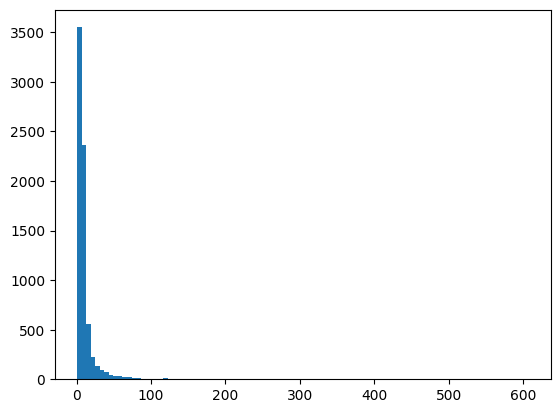

In [13]:
# draw a histogram of article counts
plt.hist(article_counts, bins=100)
plt.show()

Average deviation from the average article count in the neighborhood of a node.

In [14]:
def get_average_article_count_deviation(G, node):
    if not has_counts(G.nodes[node]):
        return -1
    
    neighbors = [ n for n in G.neighbors(node) if has_counts(G.nodes[n]) ]
    if len(neighbors) == 0:
        return -2
    
    counts = get_counts(neighbors)
    return abs(np.average(counts) - G.nodes[node]['articleCounts']['total'])
    

In [15]:
average_article_count_deviations = [ get_average_article_count_deviation(G, n) for n in G.nodes() ]

In [16]:
f_average_article_count_deviations = list(filter(lambda x: x != -1 and x!=-2, average_article_count_deviations))

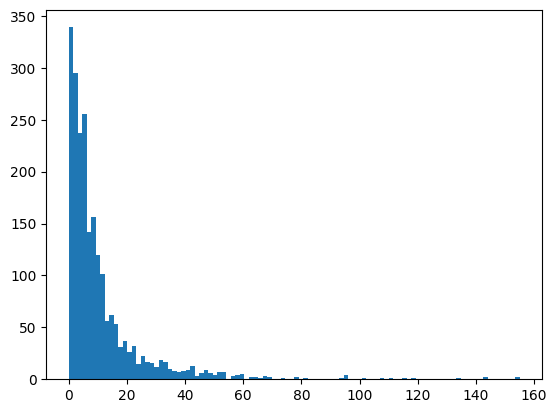

In [17]:
# draw a histogram of average article count deviations
plt.hist(f_average_article_count_deviations, bins=100)
plt.show()

## 

# Most connected node

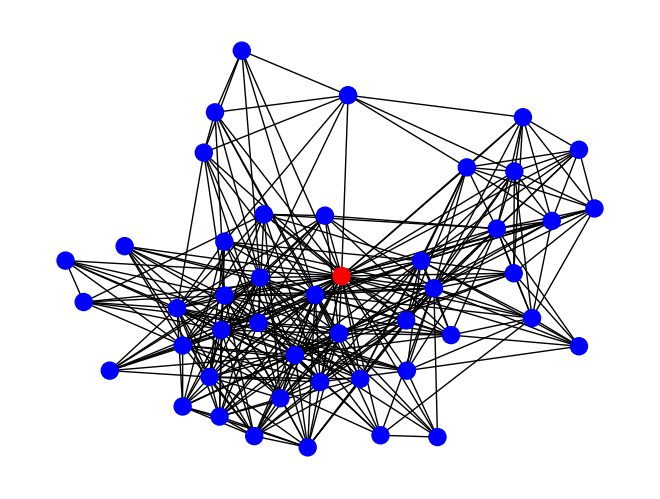

In [18]:
degrees = G.degree()
focus_node = max(degrees, key=lambda x: x[1])[0]
radius = 1

ego = nx.ego_graph(G, focus_node, radius=radius)
node_colors = ["red" if n == focus_node else "blue" for n in ego.nodes()]
pos = nx.spring_layout(ego, seed=42)

nx.draw(ego, pos, node_color=node_colors, node_size=150, with_labels=False)


In [19]:
G.nodes['e_7025']

{'eventDate': '2013-12-21',
 'articleCounts': {'spa': 23, 'total': 46, 'eng': 23},
 'multiLingInfo': {'spa': {'summary': 'Jodorkovski incia su vida de hombre libre en Berlín\nAFP\nBerlín -- El exmagnate del petróleo y opositor al Kremlin Mijail Jodorkovski, que salió de la cárcel tras ser indultado por el presidente de su país, Vladimir Putin, se reencontró con su hijo mayor, Pavel, en Berlín, donde inició este sábado su nueva vida de ...\n Magnate ruso Jodorkovsky se reúne con familiares El Nuevo Herald\nEl opositor ruso Jodorkovski se reencontró con su hijo mayor en Berlín El Universal (Venezuela)\nJodorkovski se \'implicará\' en la liberación de otros presos rusos El Mundo\nRTVE - Los Tiempos - Lainformacion.com\nlos 592 artículos informativos "',
   'title': 'Khodorkovsky begins his life of free man in berlin - mafas'},
  'eng': {'summary': 'The former oil baron Mikhail Khodorkovsky is meeting with his family in Berlin a day after being released from decade-long imprisonment in Rus

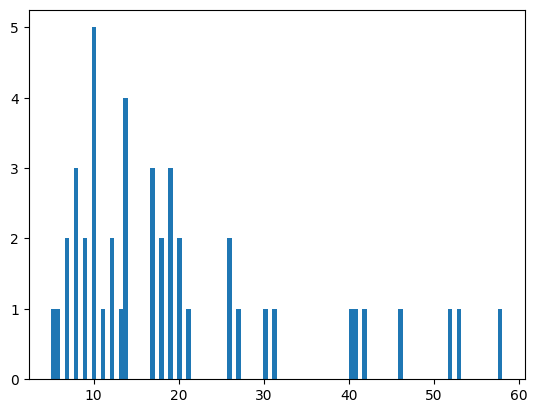

In [20]:
# histogram
plt.hist(get_counts(list(G.neighbors(focus_node))), bins=100)
plt.show()

In [21]:
deviations = [ get_average_article_count_deviation(G, n) for n in list(G.neighbors(focus_node)) ]


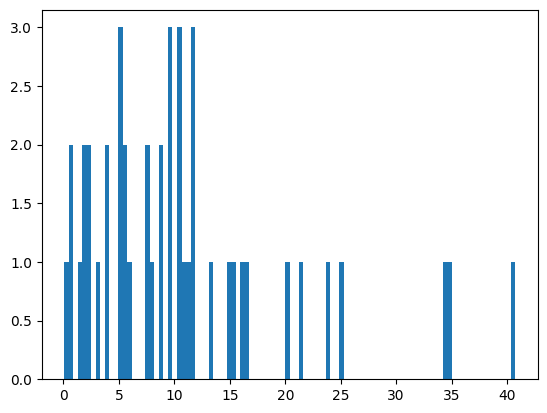

In [22]:
plt.hist(deviations, bins=100)
plt.show()

Is this cheating? The similar events are really all the same event.
It wouldn't be shocking if we only had good performance on events like this, where we're learning on the test data.